# Error Analysis: Where Does Bio Go Wrong, and When Does Bio Surpass Name?

Name classifiers do poorly for certain people. We created a bio classifier to see if we could improve upon existing off-the-shelf name classification methods. In the following analysis, we answer these questions:
1. Who did BioRaceBERT classify incorrectly? Why? (how much does it relate to our ground truth labels?)
2. How much better did BioRaceBERT do compared to RaceBERT (name classifier)?
3. How much of RaceBERT's "errors" were possibly due to ground truth label issues?
4. What information does BioRaceBERT give the model that RaceBERT does not?

# Looking at the Errors
Name classifiers are not doing well for certain people.
We will use bio classifiers to see if it does better. We see that bios do better, but we don’t know why it does better.
Our hypothesis is that names, locations, ethnicities make the impact (we could be wrong)

Let’s look at why ChatGPT and IMDb are disagreeing

Is it that the classifier is wrong, or that IMDb ground truth is wrong? There will be some overlap between where bio classifier is wrong
- 600 IMDb and ChatGPT
- 250 incorrect bio classifications
- Look at the overlap between the two

We want to talk about why the bio is going wrong (label why they are wrong and have the labels of chatgpt and IMDb disagreeing)

^ can show the figure of the failures

Bio classifier failures

## Bio Classifier Failures

In [2]:
import pandas as pd
import numpy as np

root_dir = ".."
bios = pd.read_csv(f"{root_dir}/data/BioRaceBERT-final.csv")

bios.head()

,index,name,href,race,race_cat,role,image,bio,Asian,Black,Hispanic,White,pred,pred_cat
0,0,Ang Lee,/name/nm0000487,Asian,0,Filmmaker,https://m.media-amazon.com/images/M/MV5BODA2MT...,"Born in 1954 in Pingtung, Taiwan, Ang Lee has ...",0.998528,0.000619,0.000518,0.000335,Asian,0
1,1,James Wan,/name/nm1490123,Asian,0,Filmmaker,https://m.media-amazon.com/images/M/MV5BMTY5Nz...,James Wan (born 26 February 1977) is an Austra...,0.999404,0.000226,0.000254,0.000116,Asian,0
2,2,Jon M. Chu,/name/nm0160840,Asian,0,Filmmaker,https://m.media-amazon.com/images/M/MV5BNDM0Nj...,Jon is an alumni of the USC School of Cinema-T...,0.786494,0.032934,0.010506,0.170067,Asian,0
3,3,Taika Waititi,/name/nm0169806,Asian,0,Filmmaker,https://m.media-amazon.com/images/M/MV5BMzk4MD...,"Taika Waititi, also known as Taika Cohen, hail...",0.997836,0.000499,0.000410,0.001255,Asian,0
4,4,Karyn Kusama,/name/nm0476201,Asian,0,Filmmaker,https://m.media-amazon.com/images/M/MV5BMTUzMT...,"Karyn Kusama was born on March 21, 1968 in Bro...",0.897697,0.055229,0.026547,0.020527,Asian,0


In [18]:
errors = bios[bios["race_cat"] != bios["pred_cat"]]
print(f'''BioRaceBERT failed on {len(errors)} out of {len(bios)} people in the dataset.
This is an error rate of {len(errors)/len(bios)*100:.4f}%''')

BioRaceBERT failed on 244 out of 5201 people in the dataset.
This is an error rate of 4.6914%


I saved these errors in a Google Sheet called `FailureAnalysis`, and do more data exploring there:

https://docs.google.com/spreadsheets/d/1IM_SMCTtHwrif-c8pgdyWuK7q-7_fyjFrXql8H9Milk/edit#gid=806628892

In [87]:
root_dir = ".."
error_df = pd.read_csv(f"{root_dir}/data/error_analysis/failure_analysis.csv")
error_df.head(1)

,index,name,href,id,race,race_cat,role,image,bio,Asian,...,IMDb,pred,pred_cat,correct_pred,GPT1,GPT2,Wikipedia,Agreement,Reason,Notes
0,2706,Demi Moore,/name/nm0000193,193,White,3,Actor or Actress,https://m.media-amazon.com/images/M/MV5BMTc2Mj...,"Demi Moore was born 1962 in Roswell, New Mexic...",0.03%,...,White,Hispanic,2,False,White,White,NaN,White,"Interests, experience, or wording indicate dif...",New Mexico was possibly mistaken as Mexico


                                               index  Reason
0  Provides uninformative family or birth/living ...      88
1                            Autogenerated IMDb info      51
2  Emphasizes professional roles and/or education...      35
3  Ground truth disagreement/incorrect ground tru...      22
4          Complex race boundaries and/or mixed race      14
5  Mentions other names, ethnicities, or location...      13
6  Interests, experience, or wording indicate dif...      10
7  Classifier predicted poorly given bio information      10
8                                    Not enough text       1


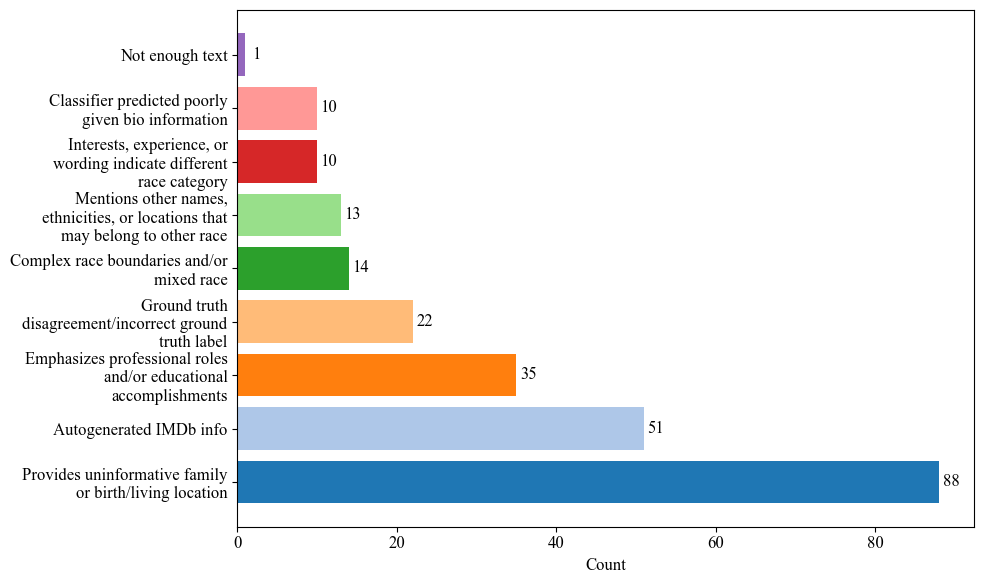

In [96]:
import matplotlib.pyplot as plt
import textwrap

# Sample data
category_counts = error_df['Reason'].value_counts().reset_index()
print(category_counts)

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Wrap the long category labels for better display
category_counts['index'] = category_counts['index'].apply(lambda x: '\n'.join(textwrap.wrap(x, width=30)))

# Generate a list of unique colors for each bar
unique_colors = plt.cm.tab20.colors[:len(category_counts)]

bars = plt.barh(category_counts['index'], category_counts['Reason'], color=unique_colors)
plt.xlabel('Count')
# plt.ylabel('Category')
# plt.title('Counts by Category')

# Set the font size to resemble Stata's default font for both numbers and text
font_properties = {'family': 'serif', 'weight': 'normal', 'size': 12}
plt.rc('font', **font_properties)

# Adjust the space for the bar text and move it slightly to the right
for bar in bars:
    width = bar.get_width()
    plt.text(width + 1.5, bar.get_y() + bar.get_height() / 2, f'{int(width)}', ha='center', va='center')

# Save the chart as an image
plt.tight_layout()  # Ensures labels are not cut off
plt.savefig(f'{root_dir}/figures/failure_reason_chart.png', dpi=300)  # Specify the desired file name and format
plt.show()


## Name Classifier Failures

Gets failures from all three name classifiers

In [31]:
import pandas as pd
import numpy as np

root_dir = ".."
nameprism = pd.read_csv(f"{root_dir}/data/name_classification/final_sample_nameprism.csv")
ethnicolr = pd.read_csv(f"{root_dir}/data/name_classification/final_sample_ethnicolr.csv")
racebert = pd.read_csv(f"{root_dir}/data/name_classification/final_sample_racebert.csv")

In [26]:
def get_failures(df, categories: list):
    '''
    Gets failed names from probability columns of name classifiers.
    
    Requires: df must contain probs from name classifier 
    Returns: pandas df
    '''

    # Get category value
    df["race"] = df["race"].astype("category")
    df["race_cat"] = df["race"].cat.codes

    # Get prediction value
    df["pred_cat"] = np.argmax(df[categories].to_numpy(), axis=1)

    # Filter if true label is different from prediction 
    failures = df[df["race_cat"] != df["pred_cat"]]

    print(f"Name classification failed on {len(failures)} names out of {len(df)}. {len(failures)/len(df)*100:.2f}% error rate")
    return failures

In [97]:
# Compile list of people who the name classifiers incorrectly classified.
nameprism_fail = get_failures(nameprism, categories=["Asian", "Black", "Hispanic", "White", "AIAN", "2PRACE"])
ethnicolr_fail = get_failures(ethnicolr, categories=["Asian", "Black", "Hispanic", "White"])
racebert_fail = get_failures(racebert, categories=["Asian", "Black", "Hispanic", "White", "aian"])

failures = pd.concat([nameprism_fail, ethnicolr_fail, racebert_fail])
len(failures)

Name classification failed on 2219 names out of 5201. 42.66% error rate
Name classification failed on 2218 names out of 5201. 42.65% error rate
Name classification failed on 1776 names out of 5201. 34.15% error rate


6213

In [99]:
name_classifiers = [nameprism_fail, ethnicolr_fail, racebert_fail]
for i, model in enumerate(name_classifiers):
    q = f"how many of {i} errors were ground truth disagreements?"
    a = model.merge(disagreement, how="inner", on="href")
    print(f"{q} {len(a)}")

how many of 0 errors were ground truth disagreements? 543
how many of 1 errors were ground truth disagreements? 517
how many of 2 errors were ground truth disagreements? 501


In [70]:
failures = failures.drop_duplicates(subset=["href"])
failures = failures.loc[:, "name":"image"]
failures.to_csv(f"{root_dir}/data/name_classification/final_sample_failures.csv")
failures.head()

,name,href,race,role,image
3,Taika Waititi,/name/nm0169806,Asian,Filmmaker,https://m.media-amazon.com/images/M/MV5BMzk4MD...
4,Karyn Kusama,/name/nm0476201,Asian,Filmmaker,https://m.media-amazon.com/images/M/MV5BMTUzMT...
5,Destin Daniel Cretton,/name/nm2308774,Asian,Filmmaker,https://m.media-amazon.com/images/M/MV5BMGQ1NT...
7,Ramin Bahrani,/name/nm1023919,Asian,Filmmaker,https://m.media-amazon.com/images/M/MV5BNTIwYT...
10,Joseph Kahn,/name/nm0994538,Asian,Filmmaker,https://m.media-amazon.com/images/M/MV5BMTM4OT...


In [71]:
# do manual analysis on failures of name classifiers? - decided not to do on all name failures
# name_df = pd.read_csv(f"{root_dir}/name_files/final_sample_failures.csv", index_col=[0])
# bio_df = pd.read_csv(f"{root_dir}/biography/BioRaceBERT-final.csv")
# print(f"This dataframe has {len(name_df)}, {len(bio_df)} people")

# merge the bios onto names
# name_df = name_df.merge(bio_df[["index", "bio"]], left_index=True, right_on="index")
# name_df.to_csv(f"{root_dir}/biography/bios_for_name_failures.csv", index=False)

## RaceBERT and BioRaceBERT Failure Overlap

The primarily contribution of our work is to see if biography-based race classification can be useful on people where name classification fails. Biographies are more difficult to obtain than names.  We look into the BioRaceBERT failures and consider the overlap with RaceBERT failures. We look specifically at RaceBERT because it is pre-trained on a similar base model.

*RaceBERT is built on RoBERTa while BioRaceBERT is fine-tuned on a pre-trained DistilBERT model

In [54]:
# manual analysis on RaceBERT
root_dir = ".."
racebert_errors = pd.read_csv(f"{root_dir}/data/name_classification/final_sample_racebert_failures.csv", index_col=[0])
print(f"This dataframe has {len(racebert_errors)} people who RaceBERT classified incorrectly")

# racebert_fails = racebert_fails.merge(bio_df[["index", "bio"]], left_index=True, right_on="index")
# racebert_fails.to_csv(f"{root_dir}/data/bios_for_racebert_failures.csv", index=False)

This dataframe has 1776 people who RaceBERT classified incorrectly


In [43]:
bios = pd.read_csv(f"{root_dir}/data/BioRaceBERT-final.csv")
bio_errors = bios[bios["race_cat"] != bios["pred_cat"]]
print(f"This dataframe has {len(bio_errors)} people who BioRaceBERT classified incorrectly")

This dataframe has 244 people who BioRaceBERT classified incorrectly


In [53]:
ground_truth = pd.read_csv(f"{root_dir}/data/RaceEthnicityGroundTruth.csv")
disagreement = ground_truth[ground_truth["Agreement"] == "DISAGREEMENT"]
print(f"This dataframe has {len(disagreement)} IMDb and ChatGPT ground truth disagreements")
disagreement.head()

This dataframe has 650 IMDb and ChatGPT ground truth disagreements


,name,href,id,IMDb,GPT1,GPT2,Wikipedia,Agreement
20,Rita Hayworth,/name/nm0000028,28,Hispanic/Latino,Hispanic/Latino,White,Hispanic/Latino,DISAGREEMENT
54,Raquel Welch,/name/nm0000079,79,Hispanic/Latino,White,White,Hispanic/Latino,DISAGREEMENT
77,Tia Carrere,/name/nm0000119,119,Asian,Mixed (Asian/White),Asian,Asian,DISAGREEMENT
93,Cameron Diaz,/name/nm0000139,139,Hispanic/Latino,White,White,Hispanic/Latino,DISAGREEMENT
140,Keanu Reeves,/name/nm0000206,206,Asian,White,White,Asian,DISAGREEMENT


In [67]:
q = "how many of RaceBERT errors were ground truth disagreements?"
a = racebert_errors.merge(disagreement, how="inner", on="href")
print(f"{q} {len(a)}")

q = "how many of BioRaceBERT errors were ground truth disagreements?"
b = bio_errors.merge(disagreement, how="inner", on="href")
print(f"{q} {len(b)}")

q = "how many common errors do RaceBERT and BioRaceBERT have?"
c = bio_errors.merge(racebert_errors, how="inner", on="href")
print(f"{q} {len(c)}")

q = "how many common errors between RaceBERT and BioRaceBERT were related to ground truth disagreement?"
d = c.merge(disagreement, how="inner", on="href")
print(f"{q} {len(d)}")


how many of RaceBERT errors were ground truth disagreements? 501
how many of BioRaceBERT errors were ground truth disagreements? 82
how many common errors do RaceBERT and BioRaceBERT have? 155
how many common errors between RaceBERT and BioRaceBERT were related to ground truth disagreement? 76


In [68]:
q = "what % of RaceBERT errors were ground truth disagreements?"
a = racebert_errors.merge(disagreement, how="inner", on="href")
print(f"{q} {len(a)/len(racebert_errors)*100:.2f}%")

q = "what % of BioRaceBERT errors were ground truth disagreements?"
b = bio_errors.merge(disagreement, how="inner", on="href")
print(f"{q} {len(b)/len(bio_errors)*100:.2f}%")

q = "what % of common errors do RaceBERT and BioRaceBERT have?"
c = bio_errors.merge(racebert_errors, how="inner", on="href")
print(f"{q} {len(c)/len(racebert_errors)*100:.2f}% of RaceBERT and {len(c)/len(bio_errors)*100:.2f}% of BioRaceBERT")

q = "what % of common errors between RaceBERT and BioRaceBERT were related to ground truth disagreement?"
d = c.merge(disagreement, how="inner", on="href")
print(f"{q} {len(d)/len(c)*100:.2f}%")

what % of RaceBERT errors were ground truth disagreements? 28.21%
what % of BioRaceBERT errors were ground truth disagreements? 33.61%
what % of common errors do RaceBERT and BioRaceBERT have? 8.73% of RaceBERT and 63.52% of BioRaceBERT
what % of common errors between RaceBERT and BioRaceBERT were related to ground truth disagreement? 49.03%
